<a href="https://colab.research.google.com/github/nayema32/Pytorch/blob/main/Handwritten_digit_recognition_using_BP_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pytorch library**

1.   torch:Pytorch core library
2.   torchvision: The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. https://pytorch.org/vision/stable/index.html
**Python library**

1.   matplotlib: https://matplotlib.org/stable/users/explain/quick_start.html
2.   numpy:https://numpy.org/doc/stable/user/quickstart.html


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
%matplotlib inline


Here we can utilize the torchvision library to utilize the available dataset in the library which is very convinient as a beginer. we already imported torchvision and dataset above as:

*  **import torchvision**

*   **from torchvision.datasets import MNIST**

We can see the sub-folder as data in working root directory after data downloading.





In [3]:
#download and define dataset
dataset = MNIST(root = 'data/', download =True, transform = ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15986354.15it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 219566.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3778855.56it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4743657.56it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We can iterate through our dataset and verify the dowloaded dataset. Since we already verified it in the folder where it shows each data has an image associated with it's label. Here, we evaluated the first image. We can check the size of our datasets.


Image shape:  torch.Size([1, 28, 28])
Label:  5
Total data 60000


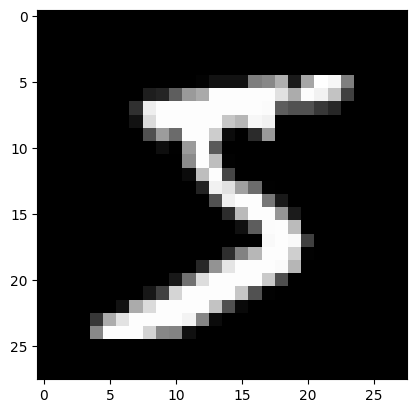

In [4]:
image, label = dataset[0]
print('Image shape: ', image.shape)
plt.imshow(image.permute(1,2,0),cmap = 'gray')
print('Label: ', label)
total_data = len(dataset)
print('Total data', total_data)


In [5]:
#Here you can iterate through other images for your understanding
# image, label = dataset[.]
# ....

In the process of training a deep learning model we need to separate our dataset in 3 vital part as:

1.   **Training set**
2.   **Validation set**
3. **Test set**

Here, we can choose different ratio like(70%-30%) and (80%-20%) based on our task requirements and previous research works.



In [6]:
val_size = 10000
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

**What is batch size and why do we need it in the deep learning model training process?**

In [7]:
batch_size = 128

Now we need to define a data loading mechanism for both training dataset and validating dataset for smooth training progress. Here, we utilized the pytorch data loading function as:

*   from torch.utils.data.dataloader import DataLoader
*  Check the function details here: https://pytorch.org/docs/stable/data.html

**So we can check lenth of training and validating cycle:

1.   Round((50000/128), 0)= 391
2.   Round((10000/128*2), 0)= 40



In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle= True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)
print(len(train_loader))
print(len(val_loader))

391
40


To understand our task broadly we can plot a batch of our training data below:

Image shape:  torch.Size([128, 1, 28, 28])


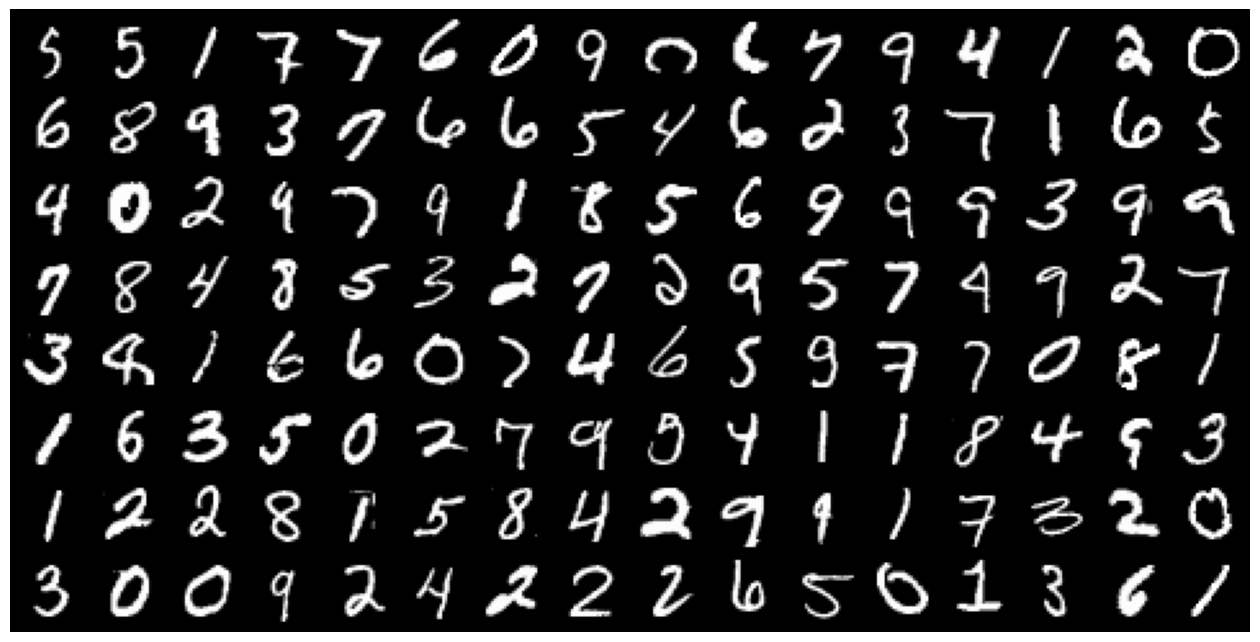

In [9]:
for images, labels in train_loader:
  print("Image shape: ", images.shape)
  plt.figure(figsize = (16,9))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

Now we have prepared our data and need to design our neural network model where we will utilized linerar layer for the input processing as **nn.Linear**: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear.

Mainly in a neural network model we have following steps:



1.   Training: need to calculate the loss(https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
2.   Validating: need to calculate the loss
3. Updating



Here, we defined the model and processing forward pass for linear processing.

In the model training we also defined the training step and validation step

In [10]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, layer1_size, layer2_size, output_size):
        super().__init__()
        # hidden layer1
        self.linear1 = nn.Linear(in_size, layer1_size)
        # hidden layer2
        self.linear2 = nn.Linear(layer1_size, layer2_size)
        #output layer3
        self.linear3 = nn.Linear(layer2_size, output_size)
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation
        out = F.relu(out)
        #Get output
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))





Now we need to define an accuracy function to measure our model performance as follows:

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Initilize the parameter for our model as:

In [12]:
input_size = 784
l1_size = 64
l2_size = 32
output_classes = 10

Initializing our model and verify the expected model parameter according to model defination:

In [13]:
model = MnistModel(input_size, l1_size, l2_size, output_classes)
for t in model.parameters():
  print(t.shape)


torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Now let's run our model with a batch of input to verify if it works according to defination. Here we can verify following parameters:

1.   Expected output shape which is (128 imaages with 10 different probability of label)
2.   Each output will have 10 label possibility for [0-9]



In [14]:
for images, labels in train_loader:
  output = model(images)
  loss = F.cross_entropy(output, labels)
  print('Loss: ', loss.item())
  break

print('Output shape: ', output.shape)
print('Sample output: ', output[0])


Loss:  2.309835195541382
Output shape:  torch.Size([128, 10])
Sample output:  tensor([ 0.0684,  0.1575, -0.2055, -0.0947, -0.0684, -0.0576, -0.0223, -0.1592,
         0.1335, -0.1389], grad_fn=<SelectBackward0>)


Using GPU

In [15]:
torch.cuda.is_available()

True

In [16]:
def get_default_device():
  """pick GPU if available else pick cpu"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    torch.device('cpu')

In [17]:
device = get_default_device()
device

device(type='cuda')

Let's move the data and model to the chossen device

In [18]:
def to_device(data, device):
  """Move tensor to choosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [19]:
for images, labels in train_loader:
  print('iamges shape: ', images.shape)
  images = to_device(images, device)
  print(images.device)
  break

iamges shape:  torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an __iter__ method to retrieve batches of data and an __len__ method to get the number of batches.

In [20]:
class DeviceDataLoader():
  """wrap datalaoder to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """yeild a batch of data after moving to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)



wrapping dataLoader using device dataloader

In [21]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
print(len(val_loader))

40


In [22]:
# for xb, yb in val_loader:
#   plt.imshow(xb[0].cpu().permute(1,2,0))
#   print('Device: ', xb.device)
#   print('yb.value: ', yb)
#   print(len(yb))
#   break


We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.

In [23]:
def evaluate(model, val_loader):
  """Evaluate the model performance on the validation set"""
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


In [24]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #validation step
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history


In [25]:
#Model on GPu
model = MnistModel(in_size=input_size, layer1_size = l1_size, layer2_size = l2_size, output_size=output_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [26]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.307541608810425, 'val_acc': 0.08876953274011612}]

In [27]:
# #with 1 hidden Layer
# history +=fit(5, 0.001, model, train_loader, val_loader)

In [28]:
#with 2 hidden Layer
history +=fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2936, val_acc: 0.0915
Epoch [1], val_loss: 2.2802, val_acc: 0.1245
Epoch [2], val_loss: 2.2650, val_acc: 0.2294
Epoch [3], val_loss: 2.2464, val_acc: 0.3195
Epoch [4], val_loss: 2.2236, val_acc: 0.3589


In [29]:
#with 2 hidden layer
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6188, val_acc: 0.6601
Epoch [1], val_loss: 0.8450, val_acc: 0.8033
Epoch [2], val_loss: 0.5720, val_acc: 0.8537
Epoch [3], val_loss: 0.4736, val_acc: 0.8734
Epoch [4], val_loss: 0.4249, val_acc: 0.8826


Text(0.5, 1.0, 'Loss vs num of epochs')

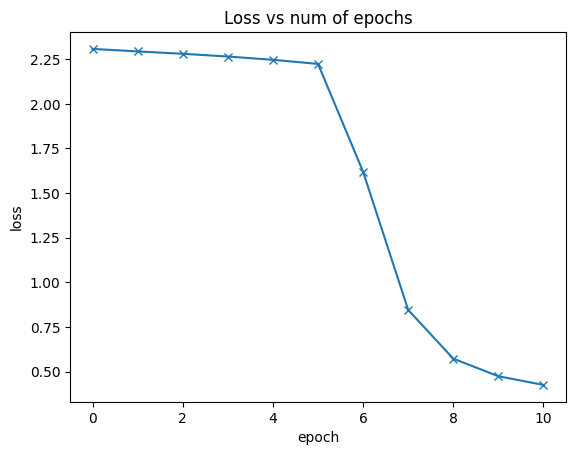

In [30]:
#with 2 hidden layer
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs num of epochs')

Text(0.5, 1.0, 'Accurary vs No. of epoch with 2 h_layer')

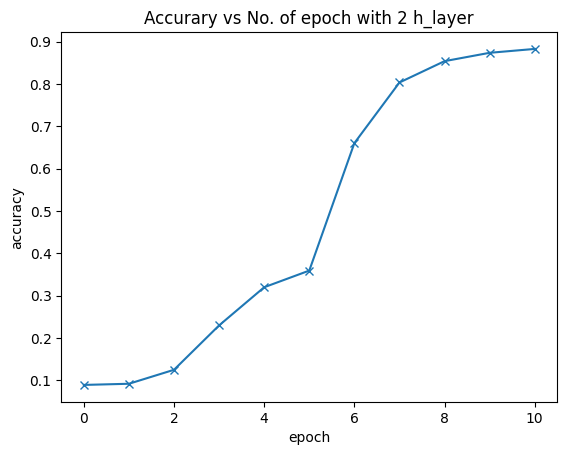

In [31]:
#2 hidden layer accuracy
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accurary vs No. of epoch with 2 h_layer')

Defining the test dataset

In [36]:
test_dataset = MNIST(root = 'data/', train=False, transform = ToTensor())

In [37]:
def predict_image(image, model):
  xb = to_device(image.unsqueeze(0), device)
  yb = model(xb)
  _,pred  = torch.max(yb, dim= 1)
  return pred[0].item()

Label:  7
predicted:  7


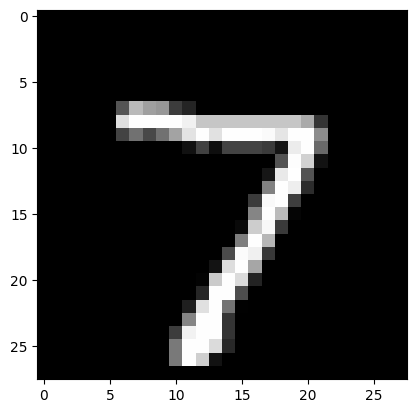

In [38]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('Label: ', label)
print('predicted: ', predict_image(img, model))

Label:  9
predicted:  7


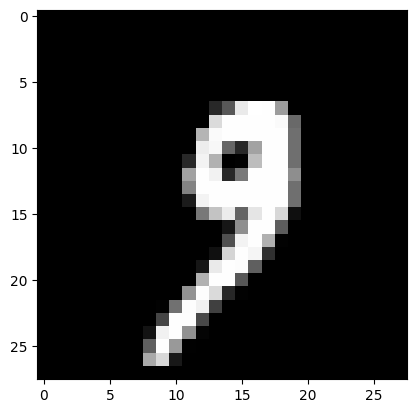

In [39]:
img, label = test_dataset[1000]
plt.imshow(img[0], cmap = 'gray')
print('Label: ', label)
print('predicted: ', predict_image(img, model))

Label:  1
predicted:  1


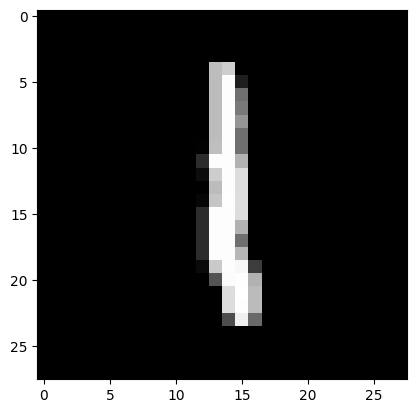

In [40]:
img, label = test_dataset[302]
plt.imshow(img[0], cmap = 'gray')
print('Label: ', label)
print('predicted: ', predict_image(img, model))

Evaluate overall loss and accuracy of the model

In [41]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size= 256), device)

In [42]:
#with 1 hidden layer
result=evaluate(model, test_loader)
result

{'val_loss': 0.39981749653816223, 'val_acc': 0.890332043170929}

In [43]:
#with 2 hidden layer
result=evaluate(model, test_loader)
result

{'val_loss': 0.39981749653816223, 'val_acc': 0.890332043170929}